# 0.0 Business Problem

Como um Consultor de Ciência de Dados para criar um modelo de alta precisão e acurácia na detecção de fraudes de transações feitas através de dispositivos móveis.

Entregáveis da consultoria:

- Modelo em produção com API.
- Relatório reportando a performance e os resultados do seu modelo em relação ao lucro e prejuízo que a empresa terá ao usar o modelo que você produziu.

  No seu relatório deve conter as respostas para as seguintes perguntas:

 -   Qual a Precisão e Acurácia do modelo?
 -   Qual a Confiabilidade do modelo em classificar as transações como legítimas ou fraudulentas?
 -   Qual o Faturamento Esperado pela Empresa se classificarmos 100% das transações com o modelo?
 -   Qual o Prejuízo Esperado pela Empresa em caso de falha do modelo?
 -   Qual o Lucro Esperado pela Blocker Fraud Company ao utilizar o modelo?

Data source: [Link](https://www.kaggle.com/ntnu-testimon/paysim1)

**Index:**

 - 0.0 Problema de Negócio
 - 0.1 Importações de bibliotecas
 - 1.0 Coleta de Dados
 - 2.0 Descrição dos Dados
 - 3.0 Limpeza de dados
 - 4.0 Feature Engineering
 - 5.0 EDA
 - 6.0 Data Preparation - Pipelines
 - 7.0 Modelagem Machine Learning / Avaliação dos Modelos
 - 8.0 Interpretação do Modelo
 - 9.0 API

**Estrátegia:**

1.0 Coleta de Dados:
- Coletar os dados utilizando pd.read_csv().

2.0 Descrição dos Dados:

- Descrever as seguintes infos por feature: percentual de missing, valores únicos, percentual de valores únicos, tipos de dados, skew, kurtosis.                                             
- Investigar isFraud vs isFlaggedFraud para determinar qual é a variável target.
- Descrever a variável 'type' com relação ao target.
- Descrever outras variáveis
 
3.0 Limpeza de dados:

- Investigar e eliminar os outliers
- Excluir os 'types' diferentes de 'TRANSFER'e 'CASH_OUT'
- Avaliar o tamanho do dataset e decidir sobre utilizar alguma estratégia de sampling.
 
4.0 Feature Engineering






Conclusões e Resultados:


## 0.1 Importações de bibliotecas

In [1]:
# Importings
import pandas as pd
import numpy as np
import time

# Importings Dask test
import dask.array as da
import dask.dataframe as dd

# Data Viz
import seaborn as sns
import matplotlib.pyplot as plt

# General Librarys
from MyToolBox import MyToolBox as mtb
from IPython.display import Image
from IPython.core.display import HTML


from imblearn.combine import SMOTETomek
from sklearn.preprocessing import OrdinalEncoder


import warnings
warnings.filterwarnings("ignore")

## 0.1 Funções auxiliares

In [73]:
def balanced_target(target, dataset, hue=None):
    """
    Function to check the balancing of the target variable.

    :target:  An pd.Series of the target variable that will be checked.
    :dataset: An Dataframe object. 
    """
    sns.set(style='darkgrid', palette='Accent')
    ax = sns.countplot(x=target, hue=hue, data=dataset)
    ax.figure.set_size_inches(10, 6)
    ax.set_title('Feature Distribution', fontsize=18, loc='center')
    ax.set_xlabel(target, fontsize=14)
    ax.set_ylabel('Count', fontsize=14)
    ax=ax

def drop_outliers(var: str, dataset: pd.DataFrame):

    # Calculando os Q1, Q3 e IQR
    Q1 = np.quantile(dataset[var], .25)
    Q3 = np.quantile(dataset[var], .75)
    IQR = Q3 - Q1

    # calculates the outliers boundaries through statistical relationship
    low = Q1 - 1.5 * IQR
    high = Q3 + 1.5 * IQR

    dados_resultado = dataset.loc[(dataset[var] > low) & (dataset[var] < high),]

    return dados_resultado

def Myheat_map(dataset, variaveis):

    df_corr = dataset[variaveis].corr()

    fig, ax = plt.subplots(figsize=(16, 10))
    # mask
    mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
    # adjust mask and df
    mask = mask[1:, :-1]
    corr = df_corr.iloc[1:,:-1].copy()
    # color map
    cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)

    # plot heatmap
    sns.heatmap(corr, mask=mask, annot=True, fmt=".2f",
                   linewidths=5, cmap=cmap, vmin=-1, vmax=1, 
                   cbar_kws={"shrink": .8}, square=True)
    yticks = [i.upper() for i in corr.index]
    xticks = [i.upper() for i in corr.columns]
    plt.yticks(plt.yticks()[0], labels=yticks, rotation=0)
    plt.xticks(plt.xticks()[0], labels=xticks, rotation=20)

    # title
    title = 'CORRELATION MATRIX\n'
    plt.title(title, loc='left', fontsize=18)
    plt.show()

# 1.0 Coleta de Dados

In [32]:
# With pandas
train = pd.read_csv('../data/trans_fraud_data.csv')
print(f'Quantidade de Colunas {train.shape[1]}')
print(f'Quantidade de Observações {train.shape[0]}')

Quantidade de Colunas 11
Quantidade de Observações 6362620


# 2.0 Descrição dos dados

- Nosso dataset não possui missing values, conforme Mydescribe.
- Nosso dataset está bastante desbalanciado, 2.1 isFraud vs isFlaggedFraud.
- A partir da análise da Skew e Kurtosis(conforme Mydescribe) podemos observar que as variáveis numericas precisaram ser transformadas. O tipo de transformação será decidido mais a frente.
- A variável isFlaggedFraud possui somente 16 observações,as quais também estão como positivas em isFraud, podemos nos desfazer dessa variável.
- A variável 'isFraud' é a nossa variável taret nesse problema!
- A variável 'type' possui 5 valores únicos. 'PAYMENT','TRANSFER','DEBIT','CASH_OUT'
- Possuímos casos de fraude somente para os tipos 'TRANSFER'e 'CASH_OUT', dessa forma podemos eliminar os outros tipos já que os mesmos só irão apresentar ao modelo exemplos de não fraude, ou seja, nosso modelo não irá conseguir modelar situações de fraude (nosso objetivo) a partir desses dados.
- A partir do describe na seção 2.2 observamos que as variáveis 'amount' e 'step' variam por diversos niveis de grandeza desde da unidade simples até a centenas, 'step', ou a milhares 'amount'. Irei criar novas variáveis aplicando Binning e excluindo as originais tendo em vista que variáveis que ultrapassam varias ordens de grandeza são problemáticas para muitos modelos.

In [6]:
# Checando os primeiros registros
train.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [7]:
# Mydescribe
pd.DataFrame({'missingPerc': train.isna().mean(),
              'uniques': train.nunique(),
              '%uniquePerc': (train.nunique()/train.shape[0])*100,
              'data_types': train.dtypes,
              'skew': train.skew(),
              'kurtosis': train.kurt()
               })

,missingPerc,uniques,%uniquePerc,data_types,skew,kurtosis
amount,0.0,5316900,83.564632,float64,30.993949,1797.956705
isFlaggedFraud,0.0,2,0.000031,int64,630.603629,397659.062500
isFraud,0.0,2,0.000031,int64,27.779538,769.702982
nameDest,0.0,2722362,42.786808,object,NaN,NaN
nameOrig,0.0,6353307,99.853629,object,NaN,NaN
newbalanceDest,0.0,3555499,55.881052,float64,19.352302,862.156508
newbalanceOrig,0.0,2682586,42.161657,float64,5.176884,32.066985
oldbalanceDest,0.0,3614697,56.811455,float64,19.921758,948.674125
oldbalanceOrg,0.0,1845844,29.010753,float64,5.249136,32.964879
step,0.0,743,0.011678,int64,0.375177,0.329071


## 2.1 isFraud vs isFlaggedFraud

Quantidade de eventos positivos - isFraud- 8213
Percentual de eventos positivos - isFraud- 0.12908204481801522

Quantidade de eventos positivos - isFlaggedFraud- 16
Percentual de eventos positivos - isFlaggedFraud- 0.12908204481801522



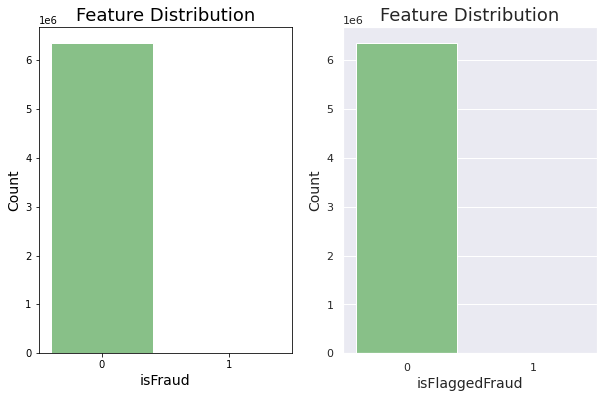

In [8]:
quant = train['isFraud'].sum()
perc = (quant/train.shape[0])*100
print(f'Quantidade de eventos positivos - isFraud- {quant}')
print(f'Percentual de eventos positivos - isFraud- {perc}\n')

quant1 = train['isFlaggedFraud'].sum()
perc1 = (quant/train.shape[0])*100
print(f'Quantidade de eventos positivos - isFlaggedFraud- {quant1}')
print(f'Percentual de eventos positivos - isFlaggedFraud- {perc1}\n')


# Plots
plt.subplot(1, 2, 1)
balanced_target('isFraud', dataset=train)

plt.subplot(1, 2, 2)
balanced_target('isFlaggedFraud', dataset=train)

In [9]:
dadosTemp = train.loc[train['isFlaggedFraud']==1,]
dadosTemp

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1,1
3247297,250,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.0,0.0,1,1
3760288,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.0,0.0,1,1
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1,1
5996407,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,1,1
5996409,425,TRANSFER,9585040.37,C452586515,19585040.37,19585040.37,C1109166882,0.0,0.0,1,1
6168499,554,TRANSFER,3576297.10,C193696150,3576297.10,3576297.10,C484597480,0.0,0.0,1,1
6205439,586,TRANSFER,353874.22,C1684585475,353874.22,353874.22,C1770418982,0.0,0.0,1,1
6266413,617,TRANSFER,2542664.27,C786455622,2542664.27,2542664.27,C661958277,0.0,0.0,1,1
6281482,646,TRANSFER,10000000.00,C19004745,10399045.08,10399045.08,C1806199534,0.0,0.0,1,1


## 2.2 Descrição variável 'type'

Valores únicos de type são ['PAYMENT' 'TRANSFER' 'CASH_OUT' 'DEBIT' 'CASH_IN']



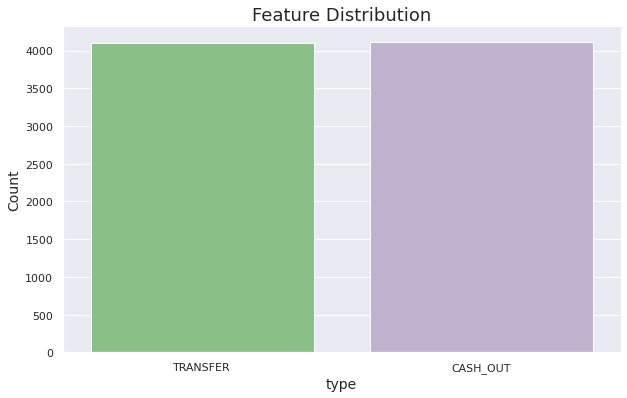

In [10]:
# Quantidade Fraud
data_temp = train.loc[train['isFraud'] == 1,]

uniq = train['type'].unique()
print(f'Valores únicos de type são {uniq}\n')
balanced_target('type', dataset=data_temp)

## 2.2 Outras Variáveis

In [11]:
# Describe
variables = ['amount','step', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
train[variables].describe().T

,count,mean,std,min,25%,50%,75%,max
amount,6362620.0,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.00,239.000,3.350000e+02,7.430000e+02
oldbalanceOrg,6362620.0,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07
newbalanceOrig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07
oldbalanceDest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08
newbalanceDest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08


### 2.2.1 Analisando 'Amount', 'oldBalanceDest', 'newBalanceDest', 'oldBalanceOrig', 'newBalanceOrig'

In [12]:
# Percentual de operações amount != de zero oldBalanceDest e newBalanceDest são iguais a 0
quant_dest = train.loc[(train['amount'] != 0) & (train['oldbalanceDest'] == 0) & (train['newbalanceDest'] == 0), ]

perc_quant_dest = round(quant_dest.shape[0]/train.shape[0], 2)*100
print(f'O percentual de casos onde o amount é diferente de 0 com oldbalanceDest e newbalanceDest iguais {perc_quant_dest}%')

O percentual de casos onde o amount é diferente de 0 com oldbalanceDest e newbalanceDest iguais 36.0%


In [13]:
# Percentual de operações amount != de zero oldBalanceOrig e newBalanceOrig são iguais a 0

quant_orig = train.loc[(train['amount'] != 0) & (train['oldbalanceOrg'] == 0) & (train['newbalanceOrig'] == 0), ]

perc_quant_orig = round(quant_orig.shape[0]/train.shape[0], 2)*100
print(f'O percentual de casos onde o amount é diferente de 0 com oldbalanceDest e newbalanceDest iguais {perc_quant_orig}%')

O percentual de casos onde o amount é diferente de 0 com oldbalanceDest e newbalanceDest iguais 33.0%


# 3.0 Limpeza de dados

- Conforme observado na etapa de descrição dos dados iremos eliminar a variável 'isFlaggedFraud', pois possui apenas 16 observações positivas sendo que as mesmas também são positivas para a variável 'isFraud'
- Conforme observado na etapa de descrição dos dados iremos eliminar as observações com 'type' diferente de 'TRANSFER' e 'CASH_OUT'
- Investigar e eliminar os outliers

## 3.1 Eliminando a variável 'isFlaggedFraud' e os 'types' PAYMENT, CASH_IN, DEBIT

In [33]:
# 'isFlaggedFraud'
train.drop('isFlaggedFraud', inplace=True, axis=1)

# PAYMENT, CASH_IN, DEBIT
index = train.loc[(train['type'] != 'TRANSFER') & (train['type'] != 'CASH_OUT'), ].index
train.drop(index, inplace=True, axis=0)

## 3.2 Eliminando Outliers

### 3.2.1 Com as classes positivas

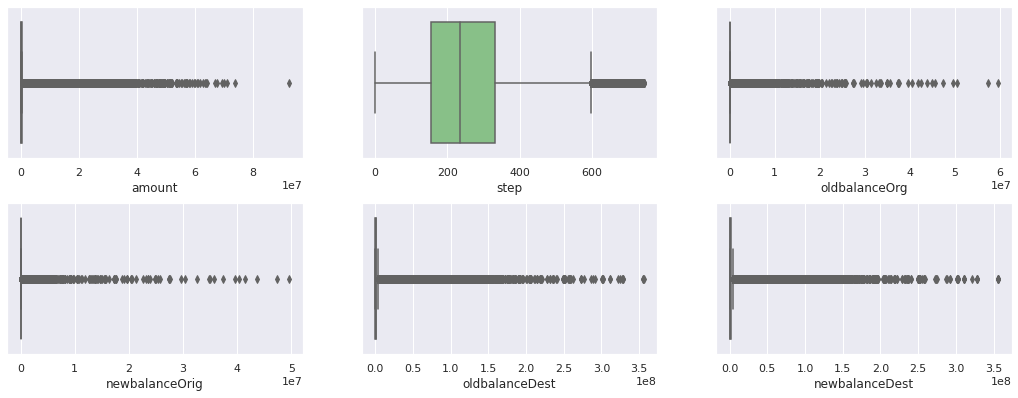

In [34]:
# Investigando Outliers
explorer = mtb.EDA(train)
explorer.multi_boxplots(['amount', 'step','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest'])

In [35]:
# Eliminando os Outliers
treino = drop_outliers('amount', train)
treino = drop_outliers('oldbalanceOrg', treino)
treino.shape

(2185708, 10)

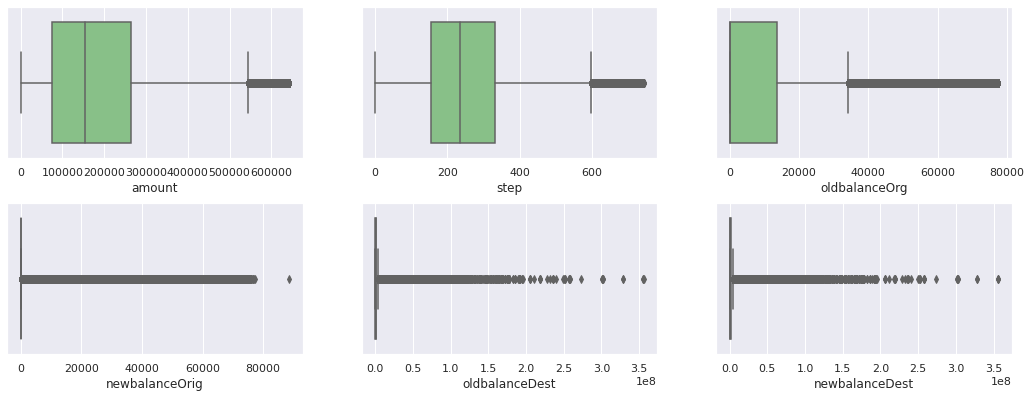

In [36]:
explorer1 = mtb.EDA(treino)
explorer1.multi_boxplots(['amount', 'step','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest'])

In [37]:
post = train.loc[train['isFraud']==1,].shape[0]
print(f'Quantidade de Classes Positivas: {post} ')

Quantidade de Classes Positivas: 8213 


In [38]:
post = treino.loc[train['isFraud']==1,].shape[0]
print(f'Quantidade de Classes Positivas: {post} ')

Quantidade de Classes Positivas: 1457 


### 3.2.2 Sem Classe Positiva

In [39]:
# Separando as observações com classe positiva
train_pos = train.loc[train['isFraud']==1,]
train_neg = train.loc[train['isFraud']==0,]

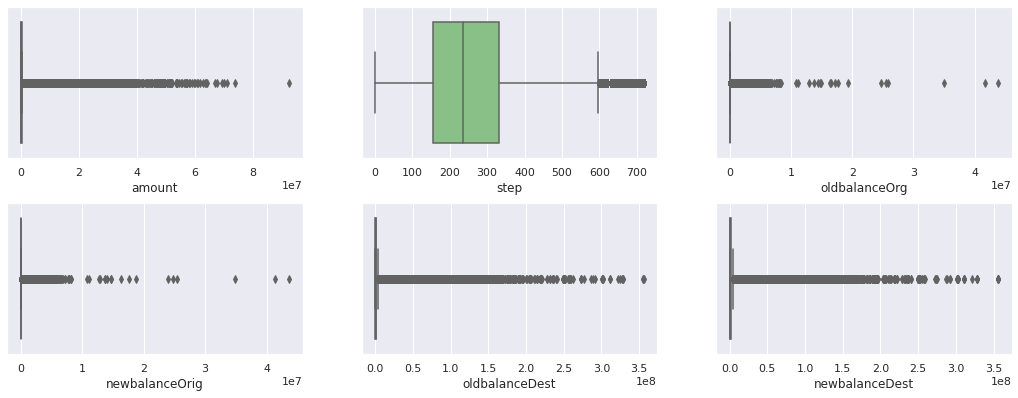

In [40]:
# Investigando Outliers
explorer = mtb.EDA(train_neg)
explorer.multi_boxplots(['amount', 'step','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest'])

In [41]:
# Eliminando os Outliers

for var in ['amount', 'step', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']:
    treino = drop_outliers(var, train_neg)

treino.shape

(2487056, 10)

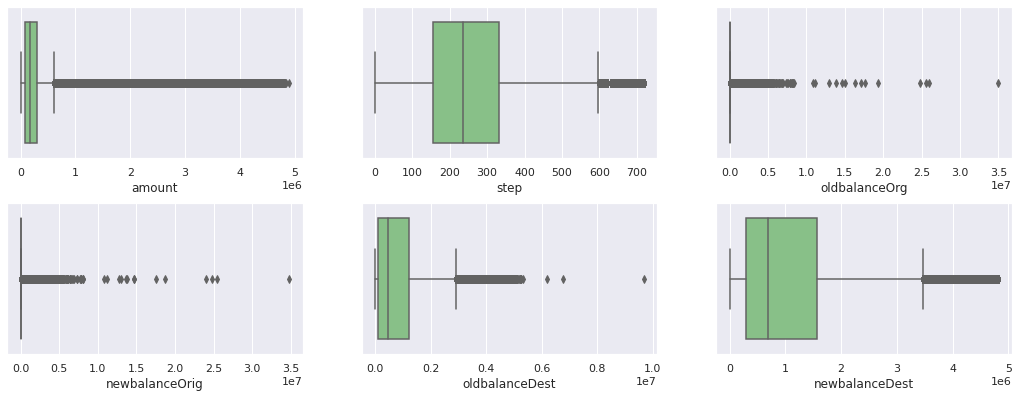

In [42]:
explorer1 = mtb.EDA(treino)
explorer1.multi_boxplots(['amount', 'step','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest'])

In [43]:
# Unindo classe negativa e positiva

treino = pd.concat([train_pos, treino], axis=0)
treino.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1
3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1
251,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1
252,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1
680,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1


# 4.0 Feature Engineering

- Criar a variável type_dest e excluir nameOrig e nameDest. Pois essas variáveis não iram trazer muita infomação.
- Criar a variável erro_transaction, esperase que 'amount' - (oldbalanceOrg - newbalanceOrig) seja igual a zero talvez erros maiores podem levar o modelo entender o evento de Fraude. 
- Criar variável por iteração 'amount' / 'step' = 'amount_step', o relacionamento do valor da trasnção por unidade de tempo pode nos ajudar a modelar o evento
- Binning 'amount', variáveis que passam por varios níveis de grandeza (dezenas, centenas, milhares) podem ser prejudicias para modelos de ML.
- Binning 'step', variáveis que passam por varios níveis de grandeza (dezenas, centenas, milhares) podem ser prejudicias para modelos de ML.

In [61]:
# dest_type; 1 - Merchant e 0-Customer e Dropping 'nameOrig', 'nameDest'
treino['dest_type'] = treino['nameDest'].apply(lambda x: 1 if x[0] == 'M' else 0)


# error_transaction
treino['error_transaction'] = treino['amount'] - (treino['oldbalanceOrg'] - treino['newbalanceOrig'])

# amount/step
treino['amount_step'] = treino['amount']/treino['step']

# Binning 'amount'
treino['amount_bin'] = pd.qcut(treino['amount'], q=5)
#treino['amount_bin'] = np.floor(np.log10(treino['amount']))

# Binning 'step'
treino['step_bin'] = pd.qcut(treino['step'], q=5)
#treino['step_bin'] = np.floor(np.log10(treino['step']))

# Binning 'oldbalanceOrg'
#treino['oldbalanceOrg_bin'] = pd.qcut(treino['oldbalanceOrg'], q=5)
#treino['oldbalanceOrg_bin'] = np.floor(np.log10(treino['oldbalanceOrg']))

# Binning 'newbalanceOrig'
#treino['newbalanceOrig_bin'] = pd.qcut(treino['newbalanceOrig'], q=5)
#treino['newbalanceOrig_bin'] = np.floor(np.log10(treino['newbalanceOrig']))

# Binning 'oldbalanceDest'
#treino['oldbalanceDest_bin'] = pd.qcut(treino['oldbalanceDest'], q=5)
#treino['oldbalanceDest_bin'] = np.floor(np.log10(treino['oldbalanceDest']))

# Binning 'newbalanceDest'
#treino['newbalanceDest_bin'] = pd.qcut(treino['newbalanceDest'], q=5)
#treino['newbalanceDest_bin'] = np.floor(np.log10(treino['newbalanceDest']))

In [62]:
# Dropouts depois do Feature Enginering
treino_clean_feat = treino.drop(['nameOrig', 'nameDest', 'amount', 'step','oldbalanceOrg'], axis=1)
treino_clean_feat.head()

,type,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,dest_type,error_transaction,amount_step,amount_bin,step_bin,oldbalanceOrg_bin
2,TRANSFER,0.0,0.0,0.0,1,0,0.0,181.0,"(-0.001, 64276.172]","(0.999, 134.0]",2.0
3,CASH_OUT,0.0,21182.0,0.0,1,0,0.0,181.0,"(-0.001, 64276.172]","(0.999, 134.0]",2.0
251,TRANSFER,0.0,0.0,0.0,1,0,0.0,2806.0,"(-0.001, 64276.172]","(0.999, 134.0]",3.0
252,CASH_OUT,0.0,26202.0,0.0,1,0,0.0,2806.0,"(-0.001, 64276.172]","(0.999, 134.0]",3.0
680,TRANSFER,0.0,0.0,0.0,1,0,0.0,20128.0,"(-0.001, 64276.172]","(0.999, 134.0]",4.0


# 5.0 EDA

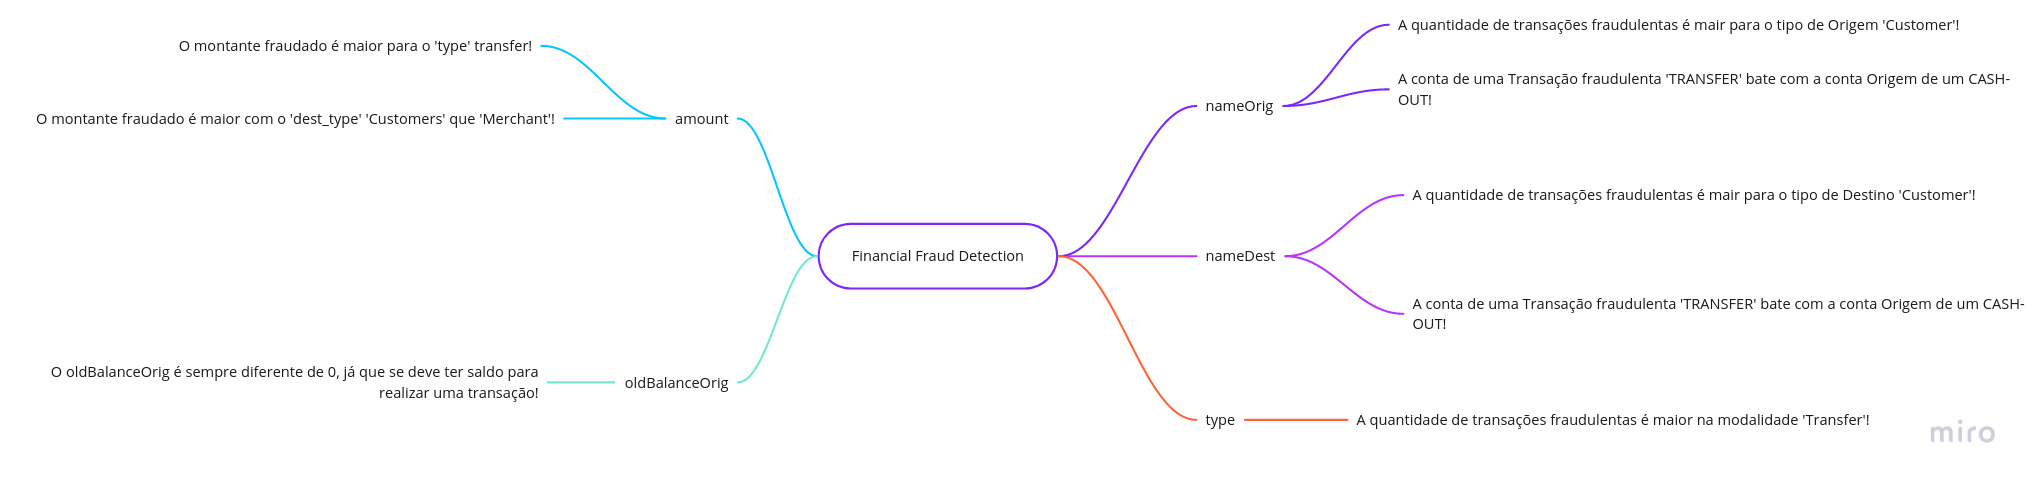

In [22]:
Image("../img/map_mental.jpg")

## 5.1 Análise Univariada

 - A partir da análise dos histogramas podemos notar um alto skew, na fase de pré-processamento será testado algumas soluções.
 - Não encontramos uma faixa de 'amount' que se destaque em quantidade de fraudes.
 - Não encontramos uma faixa step que se destaque em quantidade de fraudes.

### 5.1.1 Variáveis Numericas.

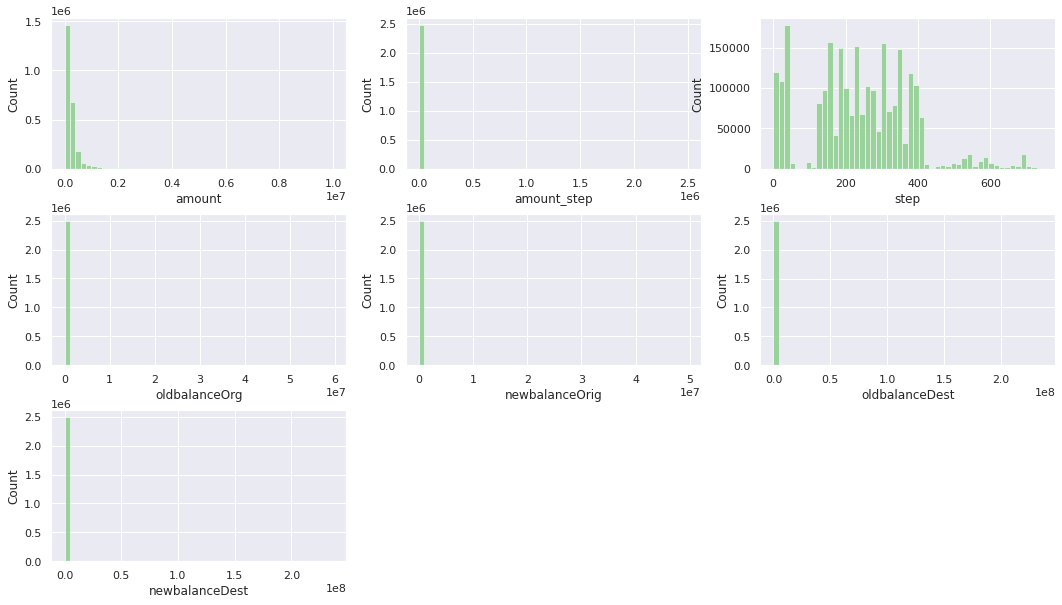

In [46]:
explorer = mtb.EDA(treino)
explorer.multi_histograms(['amount','amount_step', 'step','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest'])

### 5.1.2 Faixas de Fraude 'amount_bin'.

<AxesSubplot:xlabel='amount_bin'>

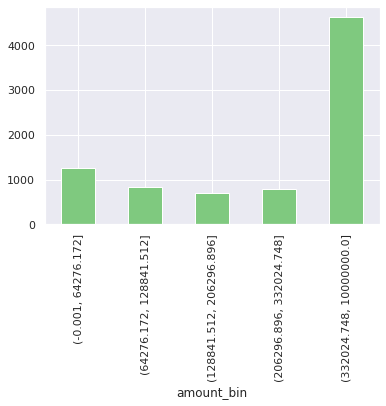

In [63]:
# Amount
obj_temp = treino.loc[treino['isFraud']==1,]
obj_temp['counter'] = 1


# Plot
obj_temp.groupby('amount_bin').count()['counter'].plot(kind='bar')

In [64]:
# Tabela com a quantidade de fraudes por faixa 'amount_bin'
obj_temp.groupby('amount_bin').count()['counter']

amount_bin
(-0.001, 64276.172]         1254
(64276.172, 128841.512]      831
(128841.512, 206296.896]     708
(206296.896, 332024.748]     792
(332024.748, 10000000.0]    4628
Name: counter, dtype: int64

### 5.1.3 Faixas de Fraude 'step_bin'.

<AxesSubplot:xlabel='step_bin'>

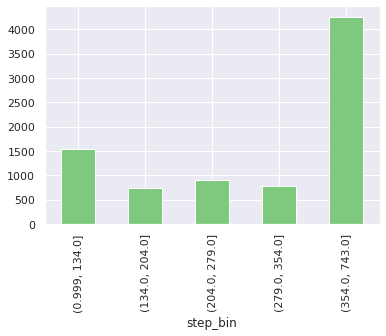

In [65]:
# Plot
obj_temp.groupby('step_bin').count()['counter'].plot(kind='bar')

In [66]:
# Tabela com a quantidade de fraudes por faixa 'step_bin'
obj_temp.groupby('step_bin').count()['counter']

step_bin
(0.999, 134.0]    1538
(134.0, 204.0]     740
(204.0, 279.0]     893
(279.0, 354.0]     784
(354.0, 743.0]    4258
Name: counter, dtype: int64

### 5.1.4 Faixas de Fraude 'oldbalanceOrg_bin'.

<AxesSubplot:xlabel='oldbalanceOrg_bin'>

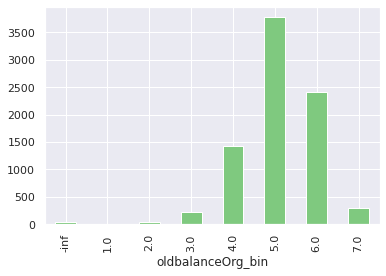

In [67]:
# Plot
obj_temp.groupby('oldbalanceOrg_bin').count()['counter'].plot(kind='bar')

In [68]:
# Tabela com a quantidade de fraudes por faixa 'oldbalanceOrg_bin'
obj_temp.groupby('oldbalanceOrg_bin').count()['counter']

oldbalanceOrg_bin
-inf      41
 1.0       2
 2.0      40
 3.0     222
 4.0    1424
 5.0    3779
 6.0    2415
 7.0     290
Name: counter, dtype: int64

## 5.2 Análise Multivariada

### 5.2.1 Variáveis Númericas

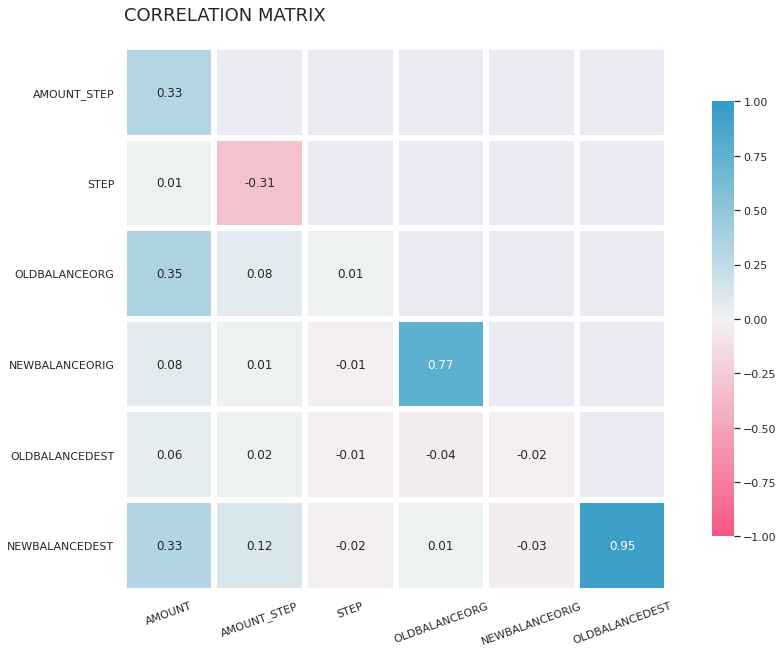

In [74]:
variaveis = ['amount','amount_step', 'step','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']
Myheat_map(dataset=treino, variaveis=variaveis)

### 5.2.1 Variáveis Númericas - Target

Text(0.5, 1.0, 'Pointbiserialr')

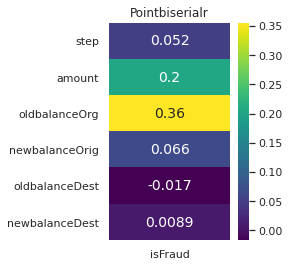

In [75]:
from scipy.stats import pointbiserialr

# Variáveis númericas
num_vars =  ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

# Correlações
corrs = [pointbiserialr(treino['isFraud'], treino[var])[0] for var in num_vars]
df_corr = pd.DataFrame({'isFraud': corrs}, index=num_vars)

# Plot Matrix
fig, ax = plt.subplots()
plt.subplot(1, 2, 1)
sns.heatmap(df_corr, annot=True, annot_kws={"fontsize":14}, cmap='viridis')
plt.title("Pointbiserialr")

### 5.2.2 Variáveis Categóricas

## 5.3 Teste de Hiposteses

Lista de Hipóteses!

1. O montante fraudado é maior para o 'type' transfer!
2. O percentual de error_transaction é maior que 50%!
3. O montante fraudado é maior com o 'dest_type' Customers que Merchant!
4. O oldbalanceOrig é sempre diferente de 0, já que se deve ter saldo para realizar uma transação!
5. A quantidade de transações fraudulentas é maior para o tipo de Origem 'Customer'!
6. A conta de uma transação fraudulenta 'TRANSFER' bate com a conta Origem de um CASH-OUT!
7. A quantidade de transações fraudulentas é maior na modalidade 'TRANSFER'!

### 5.3.1 H1 O montante fraudado é maior para o 'type' TRANSFER! [TRUE]

In [53]:
dados_temp = treino.loc[train['isFraud']==1, ]

AMOUNT_TRANSFER = dados_temp.loc[dados_temp['type']=='TRANSFER', 'amount'].sum()
AMOUNT_CASH_OUT = dados_temp.loc[dados_temp['type']=='CASH_OUT', 'amount'].sum()

print(f'\n Montante de observações TRANSFER: {AMOUNT_TRANSFER}')
print(f'Montante de observações CASH_OUT: {AMOUNT_CASH_OUT}\n')


 Montante de observações TRANSFER: 6067213184.01
Montante de observações CASH_OUT: 5989202243.83



### 5.3.2 H2 O percentual de error_transaction é maior que 50%[TRUE]!

In [60]:
# Erro
erro_acima_0 = treino.loc[treino['error_transaction'] != 0, ]

#Percentual do erro sobre dataset
perc_error = round(erro_acima_0.shape[0]/treino.shape[0]*100, 2)
print(f'O percentual de transações com erro são de {perc_error}')

O percentual de transações com erro são de 94.16


### 5.3.3 H3 O montante fraudado é maior com o 'dest_type' Customers que Merchant![TRUE]

In [55]:
dados_temp1 = treino.loc[treino['isFraud'] == 1, ['amount','dest_type']]

# Montantes
AMOUNT_CUSTOMER = round(dados_temp1.loc[dados_temp1['dest_type']==0, 'amount'].sum(),2)
AMOUNT_MERCHANT = round(dados_temp1.loc[dados_temp1['dest_type']==1, 'amount'].sum(),2)

# Report
print(f'Quantidade de observações Customers: {AMOUNT_CUSTOMER}')
print(f'Quantidade de observações Merchant: {AMOUNT_MERCHANT}\n')

Quantidade de observações Customers: 12056415427.84
Quantidade de observações Merchant: 0.0



### 5.3.4 H4 O oldbalanceOrig é sempre diferente de 0, já que se deve ter saldo para realizar uma transação![FALSE]

In [61]:
# Percentual de operações amount != de zero oldBalanceOrig e newBalanceOrig são iguais a 0

quant_orig = treino.loc[(train['amount'] != 0) & (treino['oldbalanceOrg'] == 0) & (treino['newbalanceOrig'] == 0), ]

perc_quant_orig = round(quant_orig.shape[0]/treino.shape[0], 2)*100
print(f'O percentual de casos onde o amount é diferente de 0 com oldbalanceDest e newbalanceDest iguais {perc_quant_orig}%')

O percentual de casos onde o amount é diferente de 0 com oldbalanceDest e newbalanceDest iguais 45.0%


### 5.3.4 H5 A quantidade de transações fraudulentas é maior para o tipo de Origem 'Customer'![TRUE]

In [63]:
# cheando o tipo origem.
treino['nameOrig'].str[0].unique()

array(['C'], dtype=object)

Obs: O tipo de origen 'Customer' é unico tipo de origem neste dataset!

In [62]:
# Montantes
QUANT_CUSTOMER = dados_temp1.loc[dados_temp1['dest_type']==0, 'amount'].shape[0]
QUANT_MERCHANT = dados_temp1.loc[dados_temp1['dest_type']==1, 'amount'].shape[0]

# Report
print(f'Quantidade de observações Customers: {QUANT_CUSTOMER}')
print(f'Quantidade de observações Merchant: {QUANT_MERCHANT}\n')

Quantidade de observações Customers: 8213
Quantidade de observações Merchant: 0



### 5.3.6 H6 A conta de uma transação fraudulenta 'TRANSFER' bate com a conta Origem de um CASH-OUT![FALSE]

In [71]:
CONTA_ORIG = treino.loc[(treino['isFraud']==1) & (treino['type']=='TRANSFER'), 'nameDest']
CONTA_DEST = treino.loc[(treino['isFraud']==1) & (treino['type']=='CASH_OUT'), 'nameOrig']

resultado = set(CONTA_ORIG).intersection(set(CONTA_DEST))
print(f'Contas encontradas:{len(resultado)}')

Contas encontradas:0


Nosso dataset não segue um padrão de fraude comum. de uma operação de 'TRANSFER' para uma conta fria seguida de um 'CASH_OUT'.

### 5.3.7 H7 A quantidade de transações fraudulentas é maior na modalidade 'TRANSFER'!

In [65]:
# Montantes
QUANT_TRANSFER = treino.loc[(train['isFraud']==1) & (treino['type']=='TRANSFER'), 'amount'].shape[0]
QUANT_MERCHANT = treino.loc[(train['isFraud']==1) & (treino['type']=='CASH_OUT'), 'amount'].shape[0]

# Report
print(f'Quantidade de observações Customers: {QUANT_CUSTOMER}')
print(f'Quantidade de observações Merchant: {QUANT_MERCHANT}\n')

Quantidade de observações Customers: 8213
Quantidade de observações Merchant: 4116



# 6.0 Data Preparation - Pipelines

# 7.0 Modelagem Machine Learning / Avaliação dos Modelos